In [2]:
pip install ptflops thop

Device: cuda
GPU: Tesla T4
Total GPU Memory: 15.83 GB

################################################################################
# Running: CNN_Baseline
################################################################################


/tmp/ipython-input-365851282.py:510: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Results: CNN_Baseline
Acc: 0.9910 | F1: 0.9913 | Prec: 0.9915 | Rec: 0.9912
Params: 0.0757M | FLOPs: 1.8196M | Inference: 0.6853ms



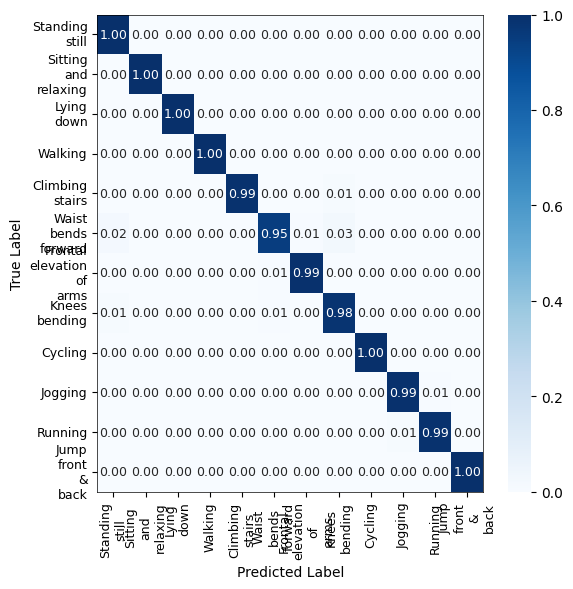


################################################################################
# Running: Transformer_Baseline
################################################################################


/tmp/ipython-input-365851282.py:510: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Results: Transformer_Baseline
Acc: 0.9913 | F1: 0.9917 | Prec: 0.9918 | Rec: 0.9916
Params: 0.0682M | FLOPs: 3.3962M | Inference: 0.7644ms



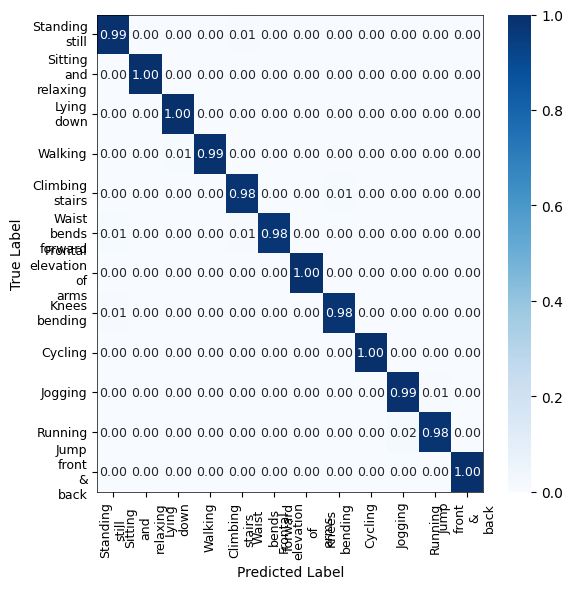


################################################################################
# Running: Ours
################################################################################


/tmp/ipython-input-365851282.py:510: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Results: Ours
Acc: 0.9942 | F1: 0.9940 | Prec: 0.9940 | Rec: 0.9940
Params: 0.0832M | FLOPs: 2.9961M | Inference: 2.2687ms



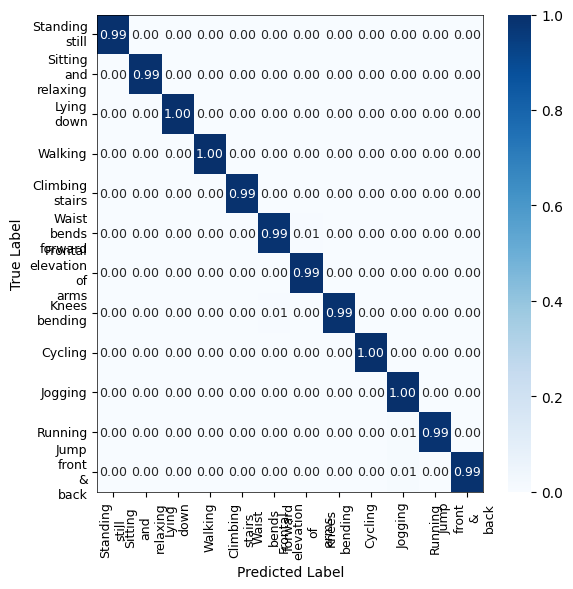

,Noise_Level,CNN_Baseline_Acc,CNN_Baseline_F1,Transformer_Baseline_Acc,Transformer_Baseline_F1,Ours_Acc,Ours_F1
0,0%,0.9910,0.9913,0.9913,0.9917,0.9942,0.9940
1,5%,0.9785,0.9790,0.9825,0.9821,0.9880,0.9882
2,10%,0.9655,0.9659,0.9717,0.9723,0.9826,0.9829
3,15%,0.9607,0.9600,0.9597,0.9618,0.9764,0.9764
4,20%,0.9351,0.9381,0.9485,0.9503,0.9713,0.9690
5,25%,0.9376,0.9397,0.9358,0.9382,0.9628,0.9632
6,Avg_Retention,0.9642,-,0.9681,-,0.9819,-


,Noise_Level,CNN_Baseline_Acc,CNN_Baseline_F1,Transformer_Baseline_Acc,Transformer_Baseline_F1,Ours_Acc,Ours_F1
0,0%,0.9910,0.9913,0.9913,0.9917,0.9942,0.9940
1,5%,0.8996,0.9059,0.9322,0.9257,0.9280,0.9291
2,10%,0.8492,0.8670,0.8729,0.8607,0.8789,0.8793
3,15%,0.7736,0.7809,0.7829,0.7745,0.8211,0.8099
4,20%,0.7277,0.6865,0.7611,0.7268,0.7383,0.7530
5,25%,0.6577,0.6122,0.6337,0.6274,0.6941,0.6937
6,Avg_Retention,0.7887,-,0.8036,-,0.8168,-


,Noise_Level,CNN_Baseline_Acc,CNN_Baseline_F1,Transformer_Baseline_Acc,Transformer_Baseline_F1,Ours_Acc,Ours_F1
0,0%,0.9910,0.9913,0.9913,0.9917,0.9942,0.9940
1,5%,0.9832,0.9836,0.9859,0.9858,0.9900,0.9901
2,10%,0.9740,0.9744,0.9793,0.9798,0.9864,0.9866
3,15%,0.9721,0.9718,0.9718,0.9733,0.9823,0.9823
4,20%,0.9539,0.9560,0.9653,0.9665,0.9790,0.9774
5,25%,0.9579,0.9593,0.9559,0.9576,0.9733,0.9734
6,Avg_Retention,0.9770,-,0.9802,-,0.9879,-


,Experiment,Accuracy,F1,Precision,Recall,Params(M),FLOPs(M),Inference(ms)
0,CNN_Baseline,0.9910,0.9913,0.9915,0.9912,0.0757,1.8196,0.6853
1,Transformer_Baseline,0.9913,0.9917,0.9918,0.9916,0.0682,3.3962,0.7644
2,Ours,0.9942,0.9940,0.9940,0.9940,0.0832,2.9961,2.2687


In [3]:
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter
from IPython.display import display
from ptflops import get_model_complexity_info
from thop import profile

def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def compute_model_stats(model: nn.Module, input_shape=(21, 50)):
    device = next(model.parameters()).device
    dummy_input = torch.randn(1, *input_shape).to(device)
    model.eval()
    classifier_original = model.classifier
    model.classifier = nn.Identity()
    macs_backbone, params_backbone = profile(model, inputs=(dummy_input,), verbose=False)
    model.classifier = classifier_original
    with torch.no_grad():
        features = model.extract_features(dummy_input)
        if isinstance(features, tuple):
            features = features[0]
    macs_cls, params_cls = profile(model.classifier, inputs=(features,), verbose=False)
    total_macs_m = (macs_backbone + macs_cls) / 1e6
    total_params_m = (params_backbone + params_cls) / 1e6
    return total_params_m, total_macs_m

def measure_inference_time(model: nn.Module, input_size=(1, 21, 50), device='cuda', n_runs=100, warmup=10):
    model.eval()
    inputs = torch.randn(input_size).to(device)
    with torch.inference_mode():
        for _ in range(warmup):
            _ = model(inputs)
    if device == 'cuda':
        torch.cuda.synchronize()
    start = time.time()
    with torch.inference_mode():
        for _ in range(n_runs):
            _ = model(inputs)
    if device == 'cuda':
        torch.cuda.synchronize()
    end = time.time()
    return (end - start) / n_runs * 1000

def plot_confusion_matrix(cm, labels, save_path='confusion_matrix.png'):
    cm_norm = cm.astype('float') / np.sum(cm, axis=1)[:, np.newaxis]
    labels_wrapped = [l.replace(' ', '\n') for l in labels]
    df = pd.DataFrame(cm_norm, index=labels_wrapped, columns=labels_wrapped)
    annot = df.copy().astype(str)
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            annot.iloc[i, j] = f"{df.iloc[i, j]:.2f}"
    plt.figure(figsize=(6, 6))
    sns.heatmap(df, annot=annot.values, fmt="", cmap="Blues", cbar=True, annot_kws={"size": 9}, vmin=0, vmax=1)
    plt.xticks(rotation=90, fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.5)
        spine.set_edgecolor('black')
    plt.xlabel('Predicted Label', fontsize=10)
    plt.ylabel('True Label', fontsize=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

class HARDataset(Dataset):
    def __init__(self, X, y, normalize=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        if normalize:
            self.mean = self.X.mean(axis=(0, 2), keepdims=True)
            self.std = self.X.std(axis=(0, 2), keepdims=True) + 1e-8
            self.X = (self.X - self.mean) / self.std
        else:
            self.mean, self.std = 0, 1
    def set_stats(self, mean, std):
        self.mean, self.std = mean, std
        self.X = (self.X - self.mean) / self.std
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), int(self.y[idx])

def load_mhealth_data(dataset_dir="MHEALTH"):
    if not os.path.exists(dataset_dir):
        print(f"Dataset directory {dataset_dir} does not exist.")
        return None, None, None, None, None
    subject_files = sorted([
        os.path.join(dataset_dir, f)
        for f in os.listdir(dataset_dir)
        if f.startswith("mHealth_subject") and f.endswith(".log")
    ])
    if not subject_files:
        print(f"No valid MHEALTH files found in {dataset_dir}.")
        return None, None, None, None, None
    all_windows = []
    all_labels = []
    window_size = 50
    step = 25
    for file_path in subject_files:
        try:
            df = pd.read_csv(file_path, sep=r'\s+', header=None, engine='python', dtype=np.float32)
            df = df.ffill().bfill()
            if df.shape[1] < 24:
                print(f"Skipping {file_path}: insufficient columns ({df.shape[1]} < 24).")
                continue
            labels = df.iloc[:, 23].values.astype(int)
            imu_cols = [0, 1, 2] + list(range(5, 23))
            features = df.iloc[:, imu_cols].values
            valid_indices = np.where(labels != 0)[0]
            if len(valid_indices) == 0:
                print(f"Skipping {file_path}: no valid labels (all labels are 0).")
                continue
            features = features[valid_indices, :]
            labels = labels[valid_indices]
            if len(features) < window_size:
                print(f"Skipping {file_path}: insufficient data points ({len(features)} < {window_size}).")
                continue
            start = 0
            while start + window_size <= len(features):
                window_data = features[start : start + window_size, :]
                window_labels_raw = labels[start : start + window_size]
                most_common_label = Counter(window_labels_raw).most_common(1)[0][0]
                all_windows.append(window_data)
                all_labels.append(most_common_label)
                start += step
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    if not all_windows:
        print("No valid data windows were extracted from the dataset.")
        return None, None, None, None, None
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(all_labels)
    X_windowed = np.array(all_windows, dtype=np.float32)
    scaler = StandardScaler()
    X_windowed_flat = X_windowed.reshape(X_windowed.shape[0], -1)
    X_windowed_flat = scaler.fit_transform(X_windowed_flat)
    X_windowed = X_windowed_flat.reshape(X_windowed.shape)
    X_windowed = np.transpose(X_windowed, (0, 2, 1))
    mhealth_activity_mapping = {
        1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down', 4: 'Walking',
        5: 'Climbing stairs', 6: 'Waist bends forward', 7: 'Frontal elevation of arms',
        8: 'Knees bending', 9: 'Cycling', 10: 'Jogging', 11: 'Running', 12: 'Jump front & back'
    }
    activity_labels = []
    class_names = list(label_encoder.classes_)
    for encoded_idx in range(len(class_names)):
        original_label = class_names[encoded_idx]
        activity_labels.append(mhealth_activity_mapping.get(original_label, f"Unknown_Activity_{original_label}"))
    X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
    return X_train, y_train, X_test, y_test, activity_labels

def get_sensor_groups():
    return {
        "axes": [
            [0, 3, 6, 9, 12, 15, 18],
            [1, 4, 7, 10, 13, 16, 19],
            [2, 5, 8, 11, 14, 17, 20]
        ],
        "modality": [
            [0, 1, 2, 6, 7, 8, 12, 13, 14, 15, 16, 17],
            [9, 10, 11, 18, 19, 20]
        ]
    }

def group_ortho_loss(group_feats: list) -> torch.Tensor:
    G = [F.normalize(g.flatten(1), dim=1) for g in group_feats]
    loss = 0.0
    n = len(G)
    for i in range(n):
        for j in range(i + 1, n):
            cov = G[i].t() @ G[j]
            loss += cov.pow(2).mean()
    return loss / max(1, (n * (n - 1)) / 2)

def fft_filter(x, cutoff_hz, fs, btype='low'):
    B, C, T = x.shape
    freqs = torch.fft.fftfreq(T, d=1/fs).to(x.device)
    x_fft = torch.fft.fft(x, dim=-1)
    if btype == 'low':
        mask = torch.abs(freqs) <= cutoff_hz
    else:
        mask = torch.abs(freqs) > cutoff_hz
    mask = mask.view(1, 1, -1).expand(B, C, -1)
    x_fft_filtered = x_fft * mask
    return torch.fft.ifft(x_fft_filtered, dim=-1).real

def compute_gravity_gyro_consistency(total_acc, gyro, gravity_est, fs, eps=1e-6):
    dt = 1.0 / fs
    B, C, T = total_acc.shape
    num_sensors = min(total_acc.shape[1] // 3, gyro.shape[1] // 3)
    total_sensor_loss = 0.0
    ux = torch.tensor([1., 0., 0.], device=total_acc.device)
    uy = torch.tensor([0., 1., 0.], device=total_acc.device)
    uz = torch.tensor([0., 0., 1.], device=total_acc.device)
    for i in range(num_sensors):
        start_idx, end_idx = i * 3, (i + 1) * 3
        sensor_gravity_est = gravity_est[:, start_idx:end_idx, :]
        sensor_gyro = gyro[:, start_idx:end_idx, :]
        gravity_norm = F.normalize(sensor_gravity_est, dim=1, eps=eps)
        loss_per_sensor = 0.0
        for t in range(1, T):
            gravity_prev = gravity_norm[:, :, t - 1]
            gravity_curr = gravity_norm[:, :, t]
            gyro_angular_vel = sensor_gyro[:, :, t - 1] * dt
            gravity_predicted = gravity_prev.clone()
            axis_x = torch.cross(gravity_prev, ux.expand_as(gravity_prev), dim=1)
            axis_y = torch.cross(gravity_prev, uy.expand_as(gravity_prev), dim=1)
            axis_z = torch.cross(gravity_prev, uz.expand_as(gravity_prev), dim=1)
            rotation_x = gyro_angular_vel[:, 0:1]
            rotation_y = gyro_angular_vel[:, 1:2]
            rotation_z = gyro_angular_vel[:, 2:3]
            gravity_predicted = gravity_predicted + rotation_x * axis_x + rotation_y * axis_y + rotation_z * axis_z
            gravity_predicted = F.normalize(gravity_predicted, dim=1, eps=eps)
            consistency_loss = F.mse_loss(gravity_predicted, gravity_curr)
            loss_per_sensor += consistency_loss
        total_sensor_loss += loss_per_sensor / (T - 1)
    return total_sensor_loss / num_sensors

def physics_guided_loss(x, gravity_scale, fs=50, hp_cut=1.5, lp_cut=0.5, eps=1e-6):
    acc_indices = [6, 7, 8, 15, 16, 17]
    gyro_indices = [9, 10, 11, 18, 19, 20]
    total_acc = x[:, acc_indices, :]
    gyro = x[:, gyro_indices, :]
    low_freq = fft_filter(total_acc, cutoff_hz=lp_cut, fs=fs, btype='low')
    gravity_mag = torch.norm(low_freq, dim=1).mean(dim=-1)
    L_grav = compute_gravity_gyro_consistency(total_acc, gyro, low_freq, fs)
    acc_high = fft_filter(total_acc, cutoff_hz=hp_cut, fs=fs, btype='high')
    gyro_high = fft_filter(gyro, cutoff_hz=hp_cut, fs=fs, btype='high')
    acc_activity = (acc_high ** 2).sum(dim=1)
    gyro_activity = (gyro_high ** 2).sum(dim=1)
    acc_norm = (acc_activity - acc_activity.mean(dim=-1, keepdims=True)) / (acc_activity.std(dim=-1, keepdims=True) + eps)
    gyro_norm = (gyro_activity - gyro_activity.mean(dim=-1, keepdims=True)) / (gyro_activity.std(dim=-1, keepdims=True) + eps)
    L_ag = F.mse_loss(acc_norm, gyro_norm)
    acc_temporal = acc_high.flatten(1)
    gyro_temporal = gyro_high.flatten(1)
    acc_t_norm = F.normalize(acc_temporal, dim=1)
    gyro_t_norm = F.normalize(gyro_temporal, dim=1)
    correlation = (acc_t_norm * gyro_t_norm).sum(dim=1).mean()
    L_ag_corr = 1.0 - correlation
    L_ag_combined = L_ag + 2.0 * L_ag_corr
    acc_jerk = torch.diff(total_acc, dim=-1)
    gyro_jerk = torch.diff(gyro, dim=-1)
    L_jerk = (acc_jerk ** 2).mean() + (gyro_jerk ** 2).mean()
    return L_grav, L_ag_combined, L_jerk

class ELKBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=31, deploy=False):
        super().__init__()
        self.deploy, self.in_channels, self.out_channels, self.kernel_size = deploy, in_channels, out_channels, kernel_size
        padding_large1, kernel_size_large2, padding_large2 = kernel_size // 2, kernel_size - 2, (kernel_size - 2) // 2
        if deploy:
            self.reparam_conv = nn.Conv1d(in_channels, in_channels, kernel_size, padding=padding_large1, groups=in_channels, bias=True)
        else:
            self.dw_large1, self.bn_large1 = nn.Conv1d(in_channels, in_channels, kernel_size, padding=padding_large1, groups=in_channels, bias=False), nn.BatchNorm1d(in_channels)
            self.dw_large2, self.bn_large2 = nn.Conv1d(in_channels, in_channels, kernel_size_large2, padding=padding_large2, groups=in_channels, bias=False), nn.BatchNorm1d(in_channels)
            self.dw_small1, self.bn_small1 = nn.Conv1d(in_channels, in_channels, 5, padding=2, groups=in_channels, bias=False), nn.BatchNorm1d(in_channels)
            self.dw_small2, self.bn_small2 = nn.Conv1d(in_channels, in_channels, 3, padding=1, groups=in_channels, bias=False), nn.BatchNorm1d(in_channels)
            self.bn_id = nn.BatchNorm1d(in_channels)
        self.pointwise = nn.Sequential(nn.Conv1d(in_channels, out_channels, 1, bias=False), nn.BatchNorm1d(out_channels))
        self.activation = nn.GELU()
    def forward(self, x):
        if not self.deploy:
            x = self.bn_large1(self.dw_large1(x)) + self.bn_large2(self.dw_large2(x)) + self.bn_small1(self.dw_small1(x)) + self.bn_small2(self.dw_small2(x)) + self.bn_id(x)
        else:
            x = self.reparam_conv(x)
        return self.pointwise(self.activation(x))
    def reparameterize(self):
        if self.deploy: return
        def _fuse(conv, bn):
            if conv is None:
                kernel = torch.zeros((self.in_channels, 1, self.kernel_size), dtype=bn.weight.dtype, device=bn.weight.device)
                kernel[:, 0, self.kernel_size // 2] = 1.0
                conv_bias = torch.zeros_like(bn.running_mean)
            else:
                kernel, conv_bias = conv.weight, torch.zeros_like(bn.running_mean)
            std = (bn.running_var + bn.eps).sqrt()
            return kernel * (bn.weight / std).reshape(-1, 1, 1), (bn.weight / std) * (conv_bias - bn.running_mean) + bn.bias
        w_l1, b_l1 = _fuse(self.dw_large1, self.bn_large1)
        w_l2, b_l2 = _fuse(self.dw_large2, self.bn_large2)
        w_s1, b_s1 = _fuse(self.dw_small1, self.bn_small1)
        w_s2, b_s2 = _fuse(self.dw_small2, self.bn_small2)
        w_id, b_id = _fuse(None, self.bn_id)
        w_l2 = F.pad(w_l2, ((self.kernel_size - self.dw_large2.kernel_size[0]) // 2,) * 2)
        w_s1 = F.pad(w_s1, ((self.kernel_size - 5) // 2,) * 2)
        w_s2 = F.pad(w_s2, ((self.kernel_size - 3) // 2,) * 2)
        self.reparam_conv = nn.Conv1d(self.in_channels, self.in_channels, self.kernel_size, padding=self.kernel_size//2, groups=self.in_channels, bias=True).to(w_l1.device)
        self.reparam_conv.weight.data = w_l1 + w_l2 + w_s1 + w_s2 + w_id
        self.reparam_conv.bias.data = b_l1 + b_l2 + b_s1 + b_s2 + b_id
        self.deploy = True
        for attr in ['dw_large1', 'bn_large1', 'dw_large2', 'bn_large2', 'dw_small1', 'bn_small1', 'dw_small2', 'bn_small2', 'bn_id']:
            if hasattr(self, attr): delattr(self, attr)

class StructureAwareEmbeddingELK(nn.Module):
    def __init__(self, sensor_groups: list, d_model: int, elk_kernel_size: int = 31):
        super().__init__()
        self.sensor_groups = sensor_groups
        self.group_embeds = nn.ModuleList([nn.Sequential(ELKBlock(len(group), d_model // 2, kernel_size=elk_kernel_size), nn.GELU()) for group in sensor_groups])
        self.mixer = nn.Sequential(nn.Conv1d((d_model // 2) * len(sensor_groups), d_model, 1, bias=False), nn.BatchNorm1d(d_model), nn.GELU())
    def forward(self, x):
        group_embeddings = [embed(x[:, group, :]) for embed, group in zip(self.group_embeds, self.sensor_groups)]
        return self.mixer(torch.cat(group_embeddings, dim=1)), group_embeddings

class TimeAwareCrossAttention(nn.Module):
    def __init__(self, dim, n_heads=8, dropout=0.0, max_rel=256, time_sigma=32.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=n_heads, dropout=dropout, batch_first=True)
        self.max_rel, self.time_sigma = max_rel, time_sigma
        self.rel_bias = nn.Parameter(torch.zeros(2 * max_rel + 1))
        nn.init.normal_(self.rel_bias, std=0.01)
        self.mask_scale = nn.Parameter(torch.tensor(0.5))
    def _relative_time_bias(self, T, Lq, device, tau_q=None):
        t_k = torch.arange(T, device=device).view(1, 1, T)
        if tau_q is None:
            tau_q = torch.linspace(0, T - 1, steps=Lq, device=device)
        tau_q = tau_q.view(1, Lq, 1)
        dt = t_k - tau_q
        dt_clip = dt.clamp(-self.max_rel, self.max_rel).long() + self.max_rel
        bias = self.rel_bias[dt_clip]
        gauss = torch.exp(-0.5 * (dt / self.time_sigma) ** 2)
        return bias + torch.log(gauss + 1e-6)
    def forward(self, q, kv, tau_q=None):
        time_bias = self._relative_time_bias(kv.shape[1], q.shape[1], q.device, tau_q)
        attn_mask = (self.mask_scale * time_bias).squeeze(0)
        out, _ = self.mha(q, kv, kv, attn_mask=attn_mask)
        return out

class MLP(nn.Module):
    def __init__(self, dim, hidden, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, dim)
        )
    def forward(self, x):
        return self.net(x)

class SelfAttention(nn.Module):
    def __init__(self, dim, n_heads=8, dropout=0.0):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)
    def forward(self, x):
        return self.attn(x, x, x)[0]

class PerceiverBackbone(nn.Module):
    def __init__(self, d_in, d_latent=256, n_latents=128, n_blocks=1, n_heads=8,
                 mlp_ratio=4, dropout=0.1, time_sigma=32.0, max_rel=128):
        super().__init__()
        self.proj_in = nn.Linear(d_in, d_latent)
        self.latents = nn.Parameter(torch.randn(1, n_latents, d_latent) * 0.02)
        self.register_buffer("latent_anchors", None, persistent=False)
        self.blocks = nn.ModuleList([
            nn.ModuleDict({
                'norm_x': nn.LayerNorm(d_latent),
                'xattn': TimeAwareCrossAttention(d_latent, n_heads, dropout, max_rel, time_sigma),
                'mlp_x': MLP(d_latent, int(d_latent * mlp_ratio), dropout),
                'norm_s': nn.LayerNorm(d_latent),
                'self_attn': SelfAttention(d_latent, n_heads, dropout),
                'mlp_s': MLP(d_latent, int(d_latent * mlp_ratio), dropout),
            }) for _ in range(n_blocks)
        ])
        self.norm_out = nn.LayerNorm(d_latent)
        self.out_dim = d_latent
    def forward(self, tokens_bt_d):
        B, T, _ = tokens_bt_d.shape
        tokens = self.proj_in(tokens_bt_d)
        latents = self.latents.expand(B, -1, -1)
        if self.latent_anchors is None or self.latent_anchors.numel() != latents.shape[1]:
            self.latent_anchors = torch.linspace(0, T - 1, steps=latents.shape[1], device=latents.device)
        for blk in self.blocks:
            latents = latents + blk['xattn'](blk['norm_x'](latents), tokens, tau_q=self.latent_anchors)
            latents = latents + blk['mlp_x'](blk['norm_x'](latents))
            latents = latents + blk['self_attn'](blk['norm_s'](latents))
            latents = latents + blk['mlp_s'](blk['norm_s'](latents))
        return self.norm_out(latents).mean(dim=1)

class UCIHarELKTimeAwarePerceiver(nn.Module):
    def __init__(self, n_channels=21, seq_length=50, d_model=128, n_classes=12, group_type="axes",
                 use_structure_embed=True, use_perceiver=True, elk_kernel_size=31, **kwargs):
        super().__init__()
        self.use_structure_embed = use_structure_embed
        self.use_perceiver = use_perceiver
        self.gravity_scale = nn.Parameter(torch.tensor(1.0))
        if use_structure_embed:
            self.embed = StructureAwareEmbeddingELK(get_sensor_groups()[group_type], d_model, elk_kernel_size)
        else:
            self.embed = nn.Sequential(ELKBlock(n_channels, d_model, elk_kernel_size), nn.GELU())
        self.pos_encoding = nn.Parameter(torch.zeros(1, d_model, seq_length))
        if use_perceiver:
            perceiver_keys = ['d_latent', 'n_latents', 'n_blocks', 'n_heads', 'mlp_ratio', 'dropout', 'time_sigma', 'max_rel']
            perceiver_kwargs = {k: v for k, v in kwargs.items() if k in perceiver_keys}
            self.backbone = PerceiverBackbone(d_in=d_model, **perceiver_kwargs)
            self.norm = nn.LayerNorm(self.backbone.out_dim)
            feat_dim = self.backbone.out_dim
        else:
            self.backbone = None
            self.pool = nn.AdaptiveAvgPool1d(1)
            self.norm = nn.LayerNorm(d_model)
            feat_dim = d_model
        self.classifier = nn.Linear(feat_dim, n_classes)
    def extract_features(self, x):
        if self.use_structure_embed:
            h, inter = self.embed(x)
        else:
            h, inter = self.embed(x), None
        if h.shape[-1] == self.pos_encoding.shape[-1]:
            h = h + self.pos_encoding
        if self.use_perceiver:
            pooled = self.norm(self.backbone(h.transpose(1, 2)))
        else:
            pooled = self.pool(h).squeeze(-1)
            pooled = self.norm(pooled)
        return (pooled, inter) if self.training and self.use_structure_embed else pooled
    def forward(self, x):
        output = self.extract_features(x)
        if self.training and self.use_structure_embed:
            features, inter = output
            logits = self.classifier(features)
            return (logits, inter)
        else:
            features = output
            logits = self.classifier(features)
            return logits
    def reparameterize(self):
        for m in self.modules():
            if isinstance(m, ELKBlock): m.reparameterize()

class SimpleCNNModel(nn.Module):
    def __init__(self, n_channels=21, seq_length=50, n_classes=12, d_model=128, **kwargs):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv1d(n_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, d_model, kernel_size=3, padding=1),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Linear(d_model, n_classes)
    def extract_features(self, x):
        features = self.backbone(x).squeeze(-1)
        return features
    def forward(self, x):
        return self.classifier(self.extract_features(x))
    def reparameterize(self):
        pass

class SimpleTransformerModel(nn.Module):
    def __init__(self, n_channels=21, seq_length=50, n_classes=12, d_model=128, n_heads=8, n_layers=2, **kwargs):
        super().__init__()
        self.proj_in = nn.Linear(n_channels, d_model)
        self.pos_encoding = nn.Parameter(torch.zeros(1, seq_length, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, dim_feedforward=d_model*4, dropout=0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, n_layers)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, n_classes)
    def extract_features(self, x):
        x = x.transpose(1, 2)
        x = self.proj_in(x) + self.pos_encoding
        x = self.transformer(x)
        features = self.norm(x.mean(dim=1))
        return features
    def forward(self, x):
        return self.classifier(self.extract_features(x))
    def reparameterize(self):
        pass

def evaluate_model(model, loader, device='cuda'):
    model.eval()
    all_preds, all_labels = [], []
    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            output = model(x)
            preds = output.argmax(dim=-1) if isinstance(output, torch.Tensor) else output[0].argmax(dim=-1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1_macro': f1_score(all_labels, all_preds, average='macro'),
        'precision_macro': precision_score(all_labels, all_preds, average='macro', zero_division=0),
        'recall_macro': recall_score(all_labels, all_preds, average='macro', zero_division=0),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

def print_results(exp_name, metrics, params, flops, inference_time, activity_names):
    print(f"\n{'='*80}\nResults: {exp_name}\n{'='*80}")
    print(f"Acc: {metrics['accuracy']:.4f} | F1: {metrics['f1_macro']:.4f} | Prec: {metrics['precision_macro']:.4f} | Rec: {metrics['recall_macro']:.4f}")
    print(f"Params: {params:.4f}M | FLOPs: {flops:.4f}M | Inference: {inference_time:.4f}ms\n{'='*80}\n")
    cm_path = f"./cm_{exp_name.replace(' ', '_')}.png"
    plot_confusion_matrix(metrics['confusion_matrix'], activity_names, cm_path)

def train_model(model, train_loader, val_loader, epochs, lr, weight_decay, device, use_physics_loss, use_group_ortho, train_mean, train_std, model_args):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = GradScaler()
    scheduler = None
    if epochs > model_args['warmup_epochs']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs - model_args['warmup_epochs'])
    mean_t = torch.from_numpy(train_mean).to(device)
    std_t = torch.from_numpy(train_std).to(device)
    best_val_acc, best_state = 0.0, None
    for epoch in range(1, epochs + 1):
        if epoch <= model_args['warmup_epochs']:
            for pg in optimizer.param_groups:
                pg["lr"] = lr * epoch / model_args['warmup_epochs']
        elif scheduler:
            scheduler.step()
        if epoch <= model_args['physics_warmup_epochs']:
            progress = epoch / model_args['physics_warmup_epochs']
            physics_factor = 0.5 * (1 + math.cos(math.pi * (1 - progress)))
        else:
            physics_factor = 1.0
        model.train()
        total_loss, loss_ce_sum = 0.0, 0.0
        correct, total = 0, 0
        for x, y in train_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                output = model(x)
                logits, inter = (output[0], output[1]) if isinstance(output, tuple) else (output, None)
                loss_ce = F.cross_entropy(logits, y, label_smoothing=model_args['label_smoothing'])
                loss = loss_ce
                loss_ce_sum += loss_ce.item() * y.size(0)
                if use_physics_loss and hasattr(model, 'gravity_scale'):
                    x_raw = x * std_t + mean_t
                    L_grav, L_ag, L_jerk = physics_guided_loss(x_raw, model.gravity_scale)
                    loss_phys = physics_factor * (model_args['w_grav'] * L_grav + model_args['w_ag'] * L_ag + model_args['w_jerk'] * L_jerk)
                    loss += loss_phys
                if use_group_ortho and inter is not None:
                    loss_orth = model_args['w_ortho'] * group_ortho_loss(inter)
                    loss += loss_orth
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item() * y.size(0)
            correct += (logits.argmax(-1) == y).sum().item()
            total += y.size(0)
        val_metrics = evaluate_model(model, val_loader, device)
        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        # Save intermediate results
        if epoch % 10 == 0:
            torch.save(best_state, f"./checkpoint_{model_args['name']}_epoch{epoch}.pth")
    if best_state:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model

def run_experiment(exp_name, model_class, model_args, train_loader, val_loader, test_loader, epochs, device, activity_names, train_mean, train_std, results_list, use_physics_loss, use_group_ortho):
    print(f"\n{'#'*80}\n# Running: {exp_name}\n{'#'*80}")
    model_args['name'] = exp_name  # Add name to model_args for checkpointing
    model = model_class(**model_args).to(device)
    model = train_model(model, train_loader, val_loader, epochs, model_args['lr'], model_args['weight_decay'], device, use_physics_loss, use_group_ortho, train_mean, train_std, model_args)
    model.reparameterize()
    metrics = evaluate_model(model, test_loader, device)
    params, flops = compute_model_stats(model)
    inference_time = measure_inference_time(model, device=device)
    print_results(exp_name, metrics, params, flops, inference_time, activity_names)
    results_list.append({
        'Experiment': exp_name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'F1': f"{metrics['f1_macro']:.4f}",
        'Precision': f"{metrics['precision_macro']:.4f}",
        'Recall': f"{metrics['recall_macro']:.4f}",
        'Params(M)': f"{params:.4f}",
        'FLOPs(M)': f"{flops:.4f}",
        'Inference(ms)': f"{inference_time:.4f}"
    })
    # Save final model
    torch.save(model.state_dict(), f"./final_model_{exp_name.replace(' ', '_')}.pth")
    return model

def add_realistic_noise(X_original, noise_type, noise_ratio, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X_noisy = X_original.copy()
    if noise_ratio <= 0:
        return X_noisy
    if noise_type == 'jitter':
        B, C, T = X_original.shape
        for b in range(B):
            for c in range(C):
                jitter_std = noise_ratio * 50
                time_noise = np.random.normal(0, jitter_std, T)
                time_indices = np.arange(T) + time_noise
                time_indices = np.clip(time_indices, 0, T-1)
                interp_values = np.interp(time_indices, np.arange(T), X_original[b, c, :])
                X_noisy[b, c, :] = interp_values.astype(np.float32)
    elif noise_type == 'dropout':
        dropout_mask = np.random.random(X_original.shape) < noise_ratio
        X_noisy[dropout_mask] = 0.0
    elif noise_type == 'window_shifting':
        B, C, T = X_original.shape
        window_size = max(1, int(T * 0.3))
        max_shift = max(1, int(noise_ratio * T * 0.8))
        for b in range(B):
            for c in range(C):
                num_windows = T // window_size
                for w in range(num_windows):
                    start_idx = w * window_size
                    end_idx = min((w + 1) * window_size, T)
                    if np.random.random() < noise_ratio:
                        shift = np.random.randint(-max_shift, max_shift + 1)
                        if shift > 0:
                            X_noisy[b, c, start_idx:end_idx-shift] = X_original[b, c, start_idx+shift:end_idx]
                            X_noisy[b, c, end_idx-shift:end_idx] = X_original[b, c, end_idx-1]
                        elif shift < 0:
                            X_noisy[b, c, start_idx-shift:end_idx] = X_original[b, c, start_idx:end_idx+shift]
                            X_noisy[b, c, start_idx:start_idx-shift] = X_original[b, c, start_idx]
    return X_noisy

if __name__ == "__main__":
    set_seed(42)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    dataset_root = "MHEALTH"
    epochs = 100
    batch_size = 512
    num_workers = 1
    base_model_args = {
        'n_channels': 21,
        'seq_length': 50,
        'd_model': 64,
        'n_classes': 12,
        'group_type': "axes",
        'elk_kernel_size': 31,
        'd_latent': 128,
        'n_latents': 32,
        'n_blocks': 1,
        'n_heads': 8,
        'mlp_ratio': 1,
        'dropout': 0.1,
        'time_sigma': 32.0,
        'max_rel': 50,
        'lr': 1e-3,
        'weight_decay': 1e-2,
        'label_smoothing': 0.05,
        'warmup_epochs': 5,
        'physics_warmup_epochs': 10,
        'w_grav': 0.05,
        'w_ag': 0.05,
        'w_jerk': 0.01,
        'w_ortho': 0.01
    }
    X_train, y_train, X_test, y_test, activity_names = load_mhealth_data(dataset_root)
    if X_train is None:
        print("Failed to load MHEALTH data. Please check the dataset directory and file contents.")
        exit()
    results_list = []
    model_configs = [
        {'name': 'CNN_Baseline', 'class': SimpleCNNModel, 'args': {**base_model_args}, 'use_physics': False, 'use_ortho': False},
        {'name': 'Transformer_Baseline', 'class': SimpleTransformerModel, 'args': {**base_model_args}, 'use_physics': False, 'use_ortho': False},
        {'name': 'Ours', 'class': UCIHarELKTimeAwarePerceiver, 'args': {**base_model_args, 'use_structure_embed': True, 'use_perceiver': True}, 'use_physics': True, 'use_ortho': True},
    ]
    trained_models = {}
    normalization_stats = None
    for config in model_configs:
        try:
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            train_idx, val_idx = next(kf.split(X_train, y_train))
            train_ds = HARDataset(X_train[train_idx], y_train[train_idx], normalize=True)
            val_ds = HARDataset(X_train[val_idx], y_train[val_idx], normalize=False)
            test_ds = HARDataset(X_test, y_test, normalize=False)
            val_ds.set_stats(train_ds.mean, train_ds.std)
            test_ds.set_stats(train_ds.mean, train_ds.std)
            normalization_stats = (train_ds.mean, train_ds.std)
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                                     num_workers=num_workers, pin_memory=True,
                                     prefetch_factor=2, persistent_workers=True)
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                                    num_workers=num_workers, pin_memory=True,
                                    prefetch_factor=2, persistent_workers=True)
            test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                                     num_workers=num_workers, pin_memory=True,
                                     prefetch_factor=2, persistent_workers=True)
            current_train_mean, current_train_std = train_ds.mean, train_ds.std
            model = run_experiment(config['name'], config['class'], config['args'], train_loader, val_loader, test_loader, epochs,
                                   device, activity_names, current_train_mean, current_train_std, results_list,
                                   config['use_physics'], config['use_ortho'])
            trained_models[config['name']] = model
            # Save intermediate results
            rst_df = pd.DataFrame(results_list)
            rst_df.to_csv('./model_comparison_results_intermediate.csv', index=False)
        except Exception as e:
            import traceback
            print(f"Error training {config['name']}: {e}")
            traceback.print_exc()
            continue
    if len(trained_models) != len(model_configs):
        print(f"Only {len(trained_models)}/{len(model_configs)} models trained successfully. Cannot proceed with noise evaluation.")
        exit()
    model_configs = [
        {'name': 'CNN_Baseline', 'class': SimpleCNNModel, 'args': {**base_model_args}, 'use_physics': False, 'use_ortho': False},
        {'name': 'Transformer_Baseline', 'class': SimpleTransformerModel, 'args': {**base_model_args}, 'use_physics': False, 'use_ortho': False},
        {'name': 'Ours', 'class': UCIHarELKTimeAwarePerceiver, 'args': {**base_model_args, 'use_structure_embed': True, 'use_perceiver': True}, 'use_physics': True, 'use_ortho': True},
    ]
    trained_models = {}
    normalization_stats = None
    for config in model_configs:
        try:
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            train_idx, val_idx = next(kf.split(X_train, y_train))
            train_ds = HARDataset(X_train[train_idx], y_train[train_idx], normalize=True)
            val_ds = HARDataset(X_train[val_idx], y_train[val_idx], normalize=False)
            test_ds = HARDataset(X_test, y_test, normalize=False)
            val_ds.set_stats(train_ds.mean, train_ds.std)
            test_ds.set_stats(train_ds.mean, train_ds.std)
            normalization_stats = (train_ds.mean, train_ds.std)
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                                    num_workers=num_workers, pin_memory=True,
                                    prefetch_factor=2, persistent_workers=True)
            val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                                   num_workers=num_workers, pin_memory=True,
                                   prefetch_factor=2, persistent_workers=True)
            test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                                    num_workers=num_workers, pin_memory=True,
                                    prefetch_factor=2, persistent_workers=True)
            current_train_mean, current_train_std = train_ds.mean, train_ds.std
            model = run_experiment(config['name'], config['class'], config['args'], train_loader, val_loader, test_loader, epochs,
                                  device, activity_names, current_train_mean, current_train_std, results_list,
                                  config['use_physics'], config['use_ortho'])
            trained_models[config['name']] = model
        except Exception as e:
            import traceback
            traceback.print_exc()
            continue
    if len(trained_models) == 0:
        exit()
    noise_types = ['jitter', 'dropout', 'window_shifting']
    display_labels = ['0%', '5%', '10%', '15%', '20%', '25%', '30%']
    noise_levels = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
    for noise_type in noise_types:
        noise_results = []
        for level, label in zip(noise_levels, display_labels):
            row = {'Noise_Level': label}
            for model_name, model in trained_models.items():
                X_test_noisy = add_realistic_noise(X_test, noise_type, level, seed=42)
                test_ds_noisy = HARDataset(X_test_noisy, y_test, normalize=False)
                test_ds_noisy.set_stats(normalization_stats[0], normalization_stats[1])
                test_loader_noisy = DataLoader(test_ds_noisy, batch_size=batch_size, shuffle=False,
                                              num_workers=num_workers, pin_memory=True,
                                              prefetch_factor=2, persistent_workers=True)
                metrics = evaluate_model(model, test_loader_noisy, device)
                row[f'{model_name}_Acc'] = f"{metrics['accuracy']:.4f}"
                row[f'{model_name}_F1'] = f"{metrics['f1_macro']:.4f}"
            noise_results.append(row)
        retention_row = {'Noise_Level': 'Avg_Retention'}
        for model_name in trained_models.keys():
            accuracies = [float(row[f'{model_name}_Acc']) for row in noise_results[1:]]
            base_acc = float(noise_results[0][f'{model_name}_Acc'])
            if base_acc > 0:
                retentions = [acc / base_acc for acc in accuracies]
                mean_retention = np.mean(retentions)
                retention_row[f'{model_name}_Acc'] = f"{mean_retention:.4f}"
                retention_row[f'{model_name}_F1'] = '-'
            else:
                retention_row[f'{model_name}_Acc'] = 'ERROR'
                retention_row[f'{model_name}_F1'] = 'ERROR'
        noise_results.append(retention_row)
        noise_df = pd.DataFrame(noise_results)
        display(noise_df)
        noise_df.to_csv(f'./{noise_type}_noise_robustness_results.csv', index=False)
    rst_df = pd.DataFrame(results_list)
    display(rst_df)
    rst_df.to_csv('./model_comparison_results.csv', index=False)

In [ ]:
ㄴ